In [1]:
!pip install gdown tbparse
!gdown 1-9laqLN6xJU1_3QR2o31omFm8qej_BH6
!gdown 1-ElKbjVTcxC2kaMGhYcT3aoI0GckibAl
!gdown 1-KCH5_k-VAMzp5nJhsBcPg1lXSQcaIyY
!gdown  1B0nD-dzBYYzWnEf0MQ2PZ5N6mxVd4nrs 

Downloading...
From (original): https://drive.google.com/uc?id=1-9laqLN6xJU1_3QR2o31omFm8qej_BH6
From (redirected): https://drive.google.com/uc?id=1-9laqLN6xJU1_3QR2o31omFm8qej_BH6&confirm=t&uuid=bcb65053-82ce-46c1-a66e-5e55913ff7b8
To: /kaggle/working/complete_structured_train_data.csv
100%|█████████████████████████████████████████| 281M/281M [00:02<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-ElKbjVTcxC2kaMGhYcT3aoI0GckibAl
To: /kaggle/working/complete_structured_test_data.csv
100%|██████████████████████████████████████| 98.0M/98.0M [00:00<00:00, 99.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-KCH5_k-VAMzp5nJhsBcPg1lXSQcaIyY
To: /kaggle/working/complete_structured_eval_data.csv
100%|███████████████████████████████████████| 42.0M/42.0M [00:00<00:00, 185MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1B0nD-dzBYYzWnEf0MQ2PZ5N6mxVd4nrs
From (redirected): https://drive.google.com/uc?id=1B0nD-dzBYYzWnEf0MQ2PZ5N6mxVd4nrs&confirm=

In [2]:
# imports to build the core enviroment functionalities
from collections import defaultdict
from typing import Optional, Callable,Any

import numpy as np
import torch
import torch.nn as nn
# imports to integrate the the data and the pretrained model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tbparse import SummaryReader
import time

2025-05-05 20:35:14.121004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746477314.359418      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746477314.428884      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
env_data = pd.read_csv('complete_structured_train_data.csv')
env_data['drill_type'] = env_data['drill_type'].apply(lambda x: 1.0 if x == 'producer' else 2)
env_data['z'] = env_data[['k_lower','k_upper']].apply(lambda x: x[0] - x[1],axis=1)
prod_values = env_data[['full_gas_pr', 'full_oil_pr', 'full_water_ir', 'full_water_pr']]
pressure_values = env_data[['assumed_bottom_hole_pressure']]
env_data = env_data[['drill_type','x', 'y', 'z','h_perm','v_perm','porosity',]]
env_data.head()

/tmp/ipykernel_31/2592493758.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  env_data['z'] = env_data[['k_lower','k_upper']].apply(lambda x: x[0] - x[1],axis=1)


,drill_type,x,y,z,h_perm,v_perm,porosity
0,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087
1,1.0,13.0,4.0,14.0,271.43484,2.714348,0.087
2,2.0,14.0,12.0,14.0,79.36990,0.793699,0.087
3,1.0,3.0,11.0,14.0,178.44434,1.784443,0.087
4,2.0,13.0,7.0,13.0,108.25170,1.082517,0.097


In [4]:
import torch

class NumericalPreprocessing:
    def __init__(self):
        self.mms_dict = {}
        self.stat_values = {}  # For PercentileTransform

    def min_max_scaling(self, array, tag):
        # Ensure the input is a PyTorch tensor
        if not isinstance(array, torch.Tensor):
            array = torch.tensor(array, dtype=torch.float32)

        min_vals = torch.min(array, dim=0, keepdim=True).values  # Min values for each column
        max_vals = torch.max(array, dim=0, keepdim=True).values  # Max values for each column

        # Ensure no division by zero if min and max are the same for a column
        range_vals = max_vals - min_vals
        range_vals = torch.where(range_vals == 0, torch.ones_like(range_vals), range_vals)

        scaled_array = (array - min_vals) / range_vals
        self.mms_dict[tag] = (range_vals, min_vals)
        return scaled_array

    def reverse_scaling(self, scaled_array, tag):
        if not isinstance(scaled_array, torch.Tensor):
            scaled_array = torch.tensor(scaled_array, dtype=torch.float32)

        range_vals, min_vals = self.mms_dict[tag]
        original_array = (scaled_array * range_vals) + min_vals
        return original_array

    def fit_distribution(self, dataset, tag):
        # Ensure the input is a PyTorch tensor
        if not isinstance(dataset, torch.Tensor):
            dataset = torch.tensor(dataset, dtype=torch.float32)

        mean = torch.mean(dataset, dim=0)
        std = torch.std(dataset, dim=0)
        self.stat_values[tag] = (mean, std)

    def transform_distribution(self, dataset, tag):
        if not self.stat_values:
            raise RuntimeError("fit_distribution method must be called before transform_percentile.")

        # Ensure the input is a PyTorch tensor
        if not isinstance(dataset, torch.Tensor):
            dataset = torch.tensor(dataset, dtype=torch.float32)

        mean, std = self.stat_values[tag]

        conditions = [
            dataset <= (mean - 3.75 * std),
            (dataset > (mean - 3.75 * std)) & (dataset <= (mean - 3.5 * std)),
            (dataset > (mean - 3.5 * std)) & (dataset <= (mean - 3.25 * std)),
            (dataset > (mean - 3.25 * std)) & (dataset <= (mean - 3 * std)),
            (dataset > (mean - 3 * std)) & (dataset <= (mean - 2.75 * std)),
            (dataset > (mean - 2.75 * std)) & (dataset <= (mean - 2.5 * std)),
            (dataset > (mean - 2.5 * std)) & (dataset <= (mean - 2.25 * std)),
            (dataset > (mean - 2.25 * std)) & (dataset <= (mean - 2 * std)),
            (dataset > (mean - 2 * std)) & (dataset <= (mean - 1.75 * std)),
            (dataset > (mean - 1.75 * std)) & (dataset <= (mean - 1.5 * std)),
            (dataset > (mean - 1.5 * std)) & (dataset <= (mean - 1.25 * std)),
            (dataset > (mean - 1.25 * std)) & (dataset <= (mean - 1 * std)),
            (dataset > (mean - 1 * std)) & (dataset <= (mean - 0.75 * std)),
            (dataset > (mean - 0.75 * std)) & (dataset <= (mean - 0.5 * std)),
            (dataset > (mean - 0.5 * std)) & (dataset <= (mean - 0.25 * std)),
            (dataset > (mean - 0.25 * std)) & (dataset <= mean),
            (dataset > mean) & (dataset <= (mean + 0.25 * std)),
            (dataset > (mean + 0.25 * std)) & (dataset <= (mean + 0.5 * std)),
            (dataset > (mean + 0.5 * std)) & (dataset <= (mean + 0.75 * std)),
            (dataset > (mean + 0.75 * std)) & (dataset <= (mean + 1 * std)),
            (dataset > (mean + 1 * std)) & (dataset <= (mean + 1.25 * std)),
            (dataset > (mean + 1.25 * std)) & (dataset <= (mean + 1.5 * std)),
            (dataset > (mean + 1.5 * std)) & (dataset <= (mean + 1.75 * std)),
            (dataset > (mean + 1.75 * std)) & (dataset <= (mean + 2 * std)),
            (dataset > (mean + 2 * std)) & (dataset <= (mean + 2.25 * std)),
            (dataset > (mean + 2.25 * std)) & (dataset <= (mean + 2.5 * std)),
            (dataset > (mean + 2.5 * std)) & (dataset <= (mean + 2.75 * std)),
            (dataset > (mean + 2.75 * std)) & (dataset <= (mean + 3 * std)),
            (dataset > (mean + 3 * std)) & (dataset <= (mean + 3.25 * std)),
            (dataset > (mean + 3.25 * std)) & (dataset <= (mean + 3.5 * std)),
            (dataset > (mean + 3.5 * std)) & (dataset <= (mean + 3.75 * std)),
            dataset > (mean + 3.75 * std),
        ]
        choices = torch.arange(2, 34, dtype=torch.float32).to(dataset.device)
        transformed_dataset = torch.select(torch.stack(conditions), dim=0, index=0) * choices[0]  # Initialize with the first condition

        for i in range(len(conditions)):
            transformed_dataset = torch.where(conditions[i], choices[i], transformed_dataset)

        return transformed_dataset

    def reverse_distribution(self, dataset, tag):
        if not self.stat_values:
            raise RuntimeError("fit_distribution method must be called before reverse_distribution.")

        # Ensure the input is a PyTorch tensor
        if not isinstance(dataset, torch.Tensor):
            dataset = torch.tensor(dataset, dtype=torch.float32)

        mean, std = self.stat_values[tag]

        reversed_dataset = torch.empty_like(dataset, dtype=torch.float32)

        reversed_dataset = torch.where(dataset == 2, (mean - 3.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 3, (mean - 3.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 4, (mean - 3.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 5, (mean - 3 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 6, (mean - 2.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 7, (mean - 2.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 8, (mean - 2.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 9, (mean - 2 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 10, (mean - 1.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 11, (mean - 1.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 12, (mean - 1.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 13, (mean - 1 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 14, (mean - 0.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 15, (mean - 0.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 16, (mean - 0.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 17, (mean - std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 18, mean, reversed_dataset)
        reversed_dataset = torch.where(dataset == 19, (mean + 0.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 20, (mean + 0.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 21, (mean + 0.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 22, (mean + 1 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 23, (mean + 1.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 24, (mean + 1.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 25, (mean + 1.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 26, (mean + 2 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 27, (mean + 2.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 28, (mean + 2.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 29, (mean + 2.75 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 30, (mean + 3 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 31, (mean + 3.25 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 32, (mean + 3.5 * std), reversed_dataset)
        reversed_dataset = torch.where(dataset == 33, (mean + 3.75 * std), reversed_dataset)

        return reversed_dataset

    def fit_transform_distribution(self, array, tag):
        self.fit_distribution(array, tag)
        transformed_array = self.transform_distribution(array, tag)
        return transformed_array

In [5]:
def assign_well_id(df):
    
    combination_to_id = {}
    next_well_id = 0
    well_ids = []

    for index, row in df.iterrows():
        x_val = row['x']
        y_val = row['y']
        z_val = row['z']
        combination = (x_val, y_val, z_val)

        if combination not in combination_to_id:
            combination_to_id[combination] = next_well_id
            next_well_id += 1

        well_ids.append(combination_to_id[combination])

    df['well_id'] = well_ids
    return df

In [6]:
npp = NumericalPreprocessing()
pv_rescaler = npp.min_max_scaling(prod_values.values,"pv")
pr_rescaler = npp.min_max_scaling(pressure_values.values,"pr")

In [7]:
wgd = assign_well_id(env_data)
wgd = wgd.sort_values(by='well_id').reset_index(drop=True)
train_data = wgd[wgd['well_id'] < 25]
test_data = wgd[(wgd['well_id'] >= 25) & (wgd['well_id'] < 50) ]
train_data.head()

,drill_type,x,y,z,h_perm,v_perm,porosity,well_id
0,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087,0
1,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087,0
2,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087,0
3,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087,0
4,2.0,23.0,10.0,14.0,73.76108,0.737611,0.087,0


In [8]:
train_data.shape

(68246, 8)

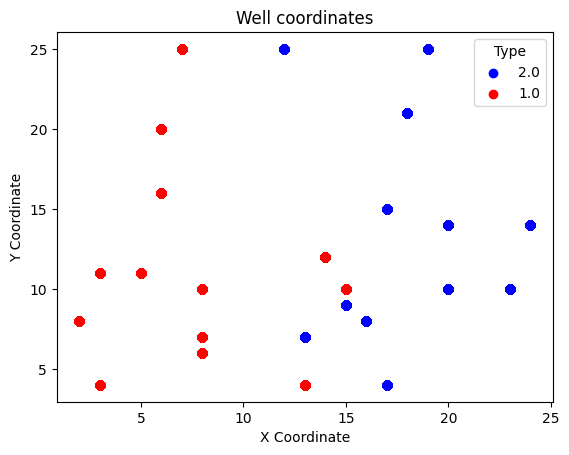

In [9]:
unique_types = train_data['drill_type'].unique()

# Define a color mapping for the two unique types
colors = {unique_types[0]: 'blue', unique_types[1]: 'red'} # You can choose any colors

# Iterate through the unique types and plot them
for type_value in unique_types:
    subset = train_data[train_data['drill_type'] == type_value]
    plt.scatter(subset['x'], subset['y'], color=colors[type_value], label=type_value)

# Add a legend
plt.legend(title='Type')

# Set the title and labels
plt.title("Well coordinates")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Show the plot
plt.show()

In [10]:
# loading the pretrained model
from transformers import DistilBertModel,DistilBertConfig
import torch.nn.init as init
class RS_BERT(nn.Module):
    def __init__(self, vocab_size, hidden_dim,dropout_prob = 0.2):
        super(RS_BERT, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.dropout_prob = dropout_prob
        
        # Load a DistilBert configuration and override the hidden dimension.
        config = DistilBertConfig.from_pretrained("distilbert-base-uncased",dropout=self.dropout_prob,
                                          attention_dropout=self.dropout_prob)
        config.dim = hidden_dim  # make sure transformer layers expect our embedding size
        
        # Instantiate the DistilBERT model.
        self.distilbert = DistilBertModel(config)
        
        # Freeze all DistilBERT parameters.
        for param in self.distilbert.parameters():
            param.requires_grad = False
        
        # Zero out the positional embeddings so that no positional information is added.
        with torch.no_grad():
            self.distilbert.embeddings.position_embeddings.weight.zero_()
        
        # Define the mlp for the four regression heads.
        self.fc1 = nn.Sequential(nn.Linear(hidden_dim, 50),nn.Tanh(),nn.Dropout(p=self.dropout_prob),nn.Linear(50, 4),
                                 nn.ReLU(),nn.Dropout(p=self.dropout_prob),nn.Linear(4, 1))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, 50),nn.Tanh(),nn.Dropout(p=self.dropout_prob),nn.Linear(50, 4),
                                 nn.ReLU(),nn.Dropout(p=self.dropout_prob),nn.Linear(4, 1))
        self.fc3 = nn.Sequential(nn.Linear(hidden_dim, 50),nn.Tanh(),nn.Dropout(p=self.dropout_prob),nn.Linear(50, 4),
                                 nn.ReLU(),nn.Dropout(p=self.dropout_prob),nn.Linear(4, 1))
        self.fc4 = nn.Sequential(nn.Linear(hidden_dim, 50),nn.Tanh(),nn.Dropout(p=self.dropout_prob),nn.Linear(50, 4),
                                 nn.ReLU(),nn.Dropout(p=self.dropout_prob),nn.Linear(4, 1))
        self.initialize_final_layer()

    '''i ranked the values of the weight initializations for each head from my observations in demo training runs 
       where i noticed a partially consistent pattern with respect to the magnitude of each  target value distribution '''
    def initialize_final_layer(self):
        fc1_final = self.fc1[-1]
        init.uniform_(fc1_final.weight, a=0.0, b=0.2)
        init.uniform_(fc1_final.bias, a=0.0, b=0.1)
        
        fc2_final = self.fc2[-1]
        init.uniform_(fc2_final.weight, a=0.0, b=0.4)
        init.uniform_(fc2_final.bias, a=0.0, b=0.1)
        
        fc3_final = self.fc3[-1]
        init.uniform_(fc3_final.weight, a=0.0, b=0.7)
        init.uniform_(fc3_final.bias, a=0.0, b=0.1)
        
        fc4_final = self.fc4[-1]
        init.uniform_(fc4_final.weight, a=0.0, b=0.5)
        init.uniform_(fc4_final.bias, a=0.0, b=0.1)
    
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Tensor of token indices with shape (batch_size, seq_length).
                              (Since the input is tabular data, 'seq_length' may be 1 or more.)
        Returns:
            torch.Tensor: Concatenated output of the four regression heads (batch_size, 4).
        """
        embeds = self.embedding(x.long()) 
        
        outputs = self.distilbert(inputs_embeds=embeds)
        # outputs.last_hidden_state has shape: (batch_size, seq_length, hidden_dim)
        
        rep = torch.mean(outputs.last_hidden_state,dim=1)  # shape: (batch_size, hidden_dim)
        
        out1 = self.fc1(rep)
        out2 = self.fc2(rep)
        out3 = self.fc3(rep)
        out4 = self.fc4(rep)
        
        output = torch.cat((out1, out2, out3, out4), dim=1)
        return output
    


vocab_size = 5000
hidden_dim= 540
dropout = 0.4
rs_model = RS_BERT(vocab_size, hidden_dim,dropout)   


state_dict = torch.load('RS_BERT_weights.pth',map_location=torch.device('cpu'))
rs_model.load_state_dict(state_dict)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/tmp/ipykernel_31/1288830452.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('RS_BERT_weights.pth',map_location=torch.device('cpu'))


<All keys matched successfully>

**Reward function formulation** <br>
NPV = ∑ [ (Revenue<sub>t</sub> - Costs<sub>t</sub>) / (1 + Discount Rate)<sup>t</sup> ] - Initial Investment
Where:

NPV: Net Present Value
Revenue<sub>t</sub>: Revenue generated in year 't'
This is typically derived from:<br>
Oil Production Rate<sub>t</sub> x Oil Price<sub>t</sub> <br>
Gas Production Rate<sub>t</sub> x Gas Price<sub>t</sub> <br>
Water Production Rate<sub>t</sub> (if applicable) x Water Value<sub>t</sub> <br>
Costs<sub>t</sub>: Operating costs in year 't', which may include:
Production Costs: Costs associated with lifting oil and gas (e.g., labor, chemicals, electricity). <br>
Transportation Costs: Costs of transporting oil and gas to market. <br>
Processing Costs: Costs of processing oil and gas (e.g., refining, gas processing). <br>
Injection Costs: Costs associated with injecting fluids (e.g., water, gas) into the reservoir. <br>
Discount Rate: The rate used to discount future cash flows to their present value. This reflects the time value of money and the risk associated with the project. <br>
Initial Investment: The upfront capital expenditure required for the project (e.g., drilling, completion, facilities).
t: The time period. <br>


Oil price as of March 11 2025 (Nigerian Bonny Light): $73.280 per barrel <br>
Gas Price as of March 12 2025 (Nigerian LNG): $0.014 per cubic feet <br>  
Generalized Operating Cost for Oil & gas fields in Nigeria: $36.5 per oil barrel <=> 6000 cubic feet of gas<br>
Initiali Investment cost for Development fields in Nigeria: $25million, we expect a well to have about 25 wells so investment each well to have an Initiali Investment cost of $1million.<br>

'∑ [ (Revenue<sub>t</sub> - Costs<sub>t</sub>) / (1 + Discount Rate)]" is Gross present value and our aim would be to maximize the GPV over time and finally calculate NPV overtime by doing GPV - initial investment. <br>
Why can't we add initial investment to the formula: because initial investment is a sunk cost, which was spent before the field was operation and hence can't be factored into operational running costs. It's just like using a certain amount of money to build a rental building, you can only confirm the value of that investment when you measure it against cashflow over a particular period of time and you can't always factor initial investment at the end of every year.


 The Reward function R would be calculated as:<br>
 R = max(GPV<sub>t</sub>) where min_P < P < max_P (P is controlled well pressure).


In [11]:
!pip install stable-baselines3 sb3-contrib
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import optuna
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.wrappers import RecordEpisodeStatistics 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 22.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uni

In [12]:
def rev_sim(data,model=rs_model):
    data = torch.tensor(data)
    data[:,-1] = npp.reverse_scaling(data[:,-1],'pr')
    with torch.no_grad():
        output =  model(data)
        output = output.detach().numpy()
        output = npp.reverse_scaling(output,'pv')
        return output

In [13]:
def npv_reward_calc(prod_vls,discount=0.5):
    gpv, opv, wiv, wpv = prod_vls[0]
    
    revenue = (opv * 73) + (gpv * 0.014)
    cost =  (opv * 36.5) +  ((gpv/6000) * 36.5) + (wiv * 1)
    gpv = ((revenue - cost) / (1 + discount))
    reward = gpv
    return reward.item()

green = episode end (truncation)
yellow = end of well timestep but not emd of field step (truncation)
red = end of well timestep + field step 

In [14]:
# the intention of environment is to sample well observations from 0 to n_well_timesteps of a single well and if specified it'll move to well_index + 1...
# ...where it'll again sample from observations from 0 to n_well_timesteps, then onto the next well, if parallelized as a field instead of a single...
#  ... well then observations would be sampled from (n_environments, 0) to (n_enviroments, n_individual_well_timesteps) and then if specified, the...
# ...field will move to field_index + 1 and the cycle continues
class ReservoirEnv(gym.Env):
    def __init__(self, well_index: int=0,well_step: int=0, n_envs: int=1, max_steps: int=3,episode_length: int=91 ,data=train_data,eval_mode = False):
        super().__init__()
        self.raw_data = data # raw data
        self.dataset = self.raw_data[self.raw_data['well_id'] == well_index].values[:,:-1] # sampled data at each timestep
        self.action_space = gym.spaces.Box(low=pr_rescaler.min().numpy().item(), high=pr_rescaler.max().numpy().item(), shape=(1,), dtype=np.float32)  # action space specifications
        self.observation_space = spaces.Box(low=0, high=5000,shape=(1,8), dtype=np.float64) # observation space specifications
        self.env_index = well_index # identifier for the enviroment (this will permanently take the index of the first well)
        self.well_index = well_index # index for a particular well, to move to another field (if specified) this would be updated by + n_envs
        self.well_step = well_step # timestep counter for each well 
        self.field_step = 1 #  # counter for every field covered
        self.field_batch = int(self.raw_data['well_id'].nunique() / n_envs) if n_envs > 1 else None # batch of fields to be covered if a field isn't being simulated (ie n_envs = 1) then it is None
        self.n_envs = n_envs # number of enviromnets, 1 is a single well and >1 is a field
        self.last_pressure = None # last pressure injected into the well. it is set to ones at inital starting reset, but at every timestep and even fresh resets, this is updated by the last action outputed by the agent (ie action at t-1)
        self.max_steps = max_steps if self.n_envs == 1 else  len(self.dataset) # max steps to be taken in an episode
        self.discount_factor = 0.5 # discount factor
        self.episode_length = episode_length # episode length
        self.current_state = None # current state
        self.truncation_flag = 'red' # flag to indicate reson for truncation, default red signifies fresh reset
        self.reward_track = 0 # reward accumulator per episode
        self.eval_mode = eval_mode # during evaluation the evaluation_policy method counts termination/truncation signals as episode ends, so when eval_mode is confirmed termination = True

    
    def manual_reset(self): # we can't use the inbuilt self.reset else it'll mess with vecEnv
        self.last_pressure = np.ones((1,1)) if self.last_pressure is None else self.last_pressure
        self.well_index = self.env_index
        self.well_step = 0
        self.dataset = self.raw_data[self.raw_data['well_id'] == self.well_index].values[:,:-1]
        self.current_state = np.concatenate([self.dataset[self.well_step].reshape(1,7),self.last_pressure],axis=1)
        self.max_steps = len(self.dataset)

    def reset(self, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.start_time = time.time()
        if self.truncation_flag == 'yellow':
            print(f'termination of enviroment {self.env_index} in field {self.field_step} of {self.field_batch}')
            self.field_step += 1 # update number of field covered
            self.well_step = 0 # reset timestep index
            self.well_index += self.n_envs # increase well index by n_envs
            self.dataset = self.raw_data[self.raw_data['well_id'] == self.well_index].values[:,:-1] # index the new well
            self.max_steps = len(self.dataset)
            self.last_pressure = np.ones((1,1))   # reseting pressure injection value for the new well
            self.current_state = np.concatenate([self.dataset[self.well_step].reshape(1,7),self.last_pressure],axis=1) # get observation from the new well
            print(f'starting enviroment {self.env_index} in field {self.field_step} of {self.field_batch}') 
        else:
            self.manual_reset()
            
        observation = self.current_state
        info = {'current_field':self.field_step,'real_well_index': self.well_index, 'well_index_for_field': (self.field_step * self.n_envs) - self.well_index ,'step': self.well_step,}
        return observation, info

    
    def step(self, action):
        self.current_state[:,-1] =  action
        sim_input = self.current_state.copy()
        sim_output  = rev_sim(sim_input)
        reward = npv_reward_calc(sim_output,discount=self.discount_factor)
        self.reward_track += reward
        self.well_step += 1
        old_obs = self.current_state[:,:-1]
        episode_signal = False
        terminated = False
        truncated = False


        
        if self.well_step < self.max_steps-1: # if the run is still within the timesteps of a simulation
            if self.well_step % self.episode_length == 0:
                episode_signal = True
                if self.eval_mode == True:
                    terminated = True
            self.last_pressure = action.reshape(1,1)
            self.current_state = np.concatenate([self.dataset[self.well_step].reshape(1,7),self.last_pressure],axis=1)
              
        elif self.well_step >= self.max_steps-1 and self.field_batch > 1 and self.field_step != self.field_batch: # if the final timestep for a well has been reached + if there are more than 1 batch of field well data so a new well from the next batch be indexed
            self.truncation_flag = 'yellow'
            truncated = True
        else:
            print(f'reset of enviroment {self.env_index}, in absence (or end) of field batch')
            self.manual_reset()
        
        observation = self.current_state
        #if np.array_equal(old_obs,observation[:,:-1]) == False and self.truncation_flag != 'yellow':
            #raise Exception('''The well progression isn't temporal ie 
                          #the environment is moving through different wells per timestep''')
        
        info = {'current_field':self.field_step,'real_well_index': self.well_index, 
                'well_index_for_field': (self.field_step * self.n_envs) - self.well_index, 'step': self.well_step}
        if episode_signal == True:
            info['episode'] = {}
            info['episode']['r'] = self.reward_track # reward
            info['episode']['l'] = self.well_step / self.episode_length # episode length
            info['episode']['t'] = time.time() - self.start_time # time per episode
            self.start_time = time.time()
            self.reward_track = 0
        return observation, reward,terminated ,truncated, info
    

    def render(self):
        pass

    def close(self):
        pass
    

In [15]:
env = ReservoirEnv()
check_env(env)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [16]:
num_envs = 25
def make_reservoir_env(data, rank: int, base_initial_index: int, n_envs: int,eval_mode:bool):
    def _init():
        # Each instance starts at base_initial_index plus its rank.
        well_index = base_initial_index + rank
        return ReservoirEnv(well_index=well_index, n_envs=n_envs,data=data,eval_mode = eval_mode)
    return _init

dummy_vec_env = DummyVecEnv([make_reservoir_env(data=train_data,rank=rank,base_initial_index=0, n_envs=num_envs,eval_mode= False)
                         for rank in range(num_envs)])
vec_env = VecMonitor(dummy_vec_env)

In [17]:
obs = vec_env.reset()
print("Initial observations shape:", obs.shape)

Initial observations shape: (25, 1, 8)


In [18]:
# Sample actions for each parallel environment and take a step.
for i in range(20):
    actions = [vec_env.action_space.sample() for _ in range(vec_env.num_envs)]
    obs, rewards, dones, infos = vec_env.step(actions)
    print("Step rewards:", np.mean(rewards))

Step rewards: 21776.904
Step rewards: 26494.016
Step rewards: 24685.545
Step rewards: 31246.936
Step rewards: 19247.732
Step rewards: 18619.367
Step rewards: 31060.002
Step rewards: 17657.559
Step rewards: 21988.727
Step rewards: 23804.215
Step rewards: 11119.829
Step rewards: 13087.579
Step rewards: 15755.287
Step rewards: 27567.008
Step rewards: 14511.263
Step rewards: 24930.39
Step rewards: 15680.245
Step rewards: 26555.357
Step rewards: 31934.322
Step rewards: 12754.638


In [19]:
t_timesteps = 91250 # represetning 3650 days/10 years per well
n_steps = int(t_timesteps/(25 * 10))
batch_size = int((n_steps * 25) / 60)
epoch = 5
t_timesteps,n_steps, batch_size, epoch

(91250, 365, 152, 5)

In [20]:
import math

def custom_round_up(number):
    integer_part = int(number)
    fractional_part = number - integer_part

    if fractional_part > 0:
        return integer_part + 1
    else:
        return integer_part

In [21]:
def quaterize(day_of_year):
    if 1 <= day_of_year <= 91:
        return 1
    elif 92 <= day_of_year <= 183:
        return 2
    elif 184 <= day_of_year <= 275:
        return 3
    elif 276 <= day_of_year <= 365:
        return 4
    return None

In [22]:
imp_dict = {'value':[]} # improvement recording dict

In [23]:
from stable_baselines3.common.callbacks import BaseCallback

class PrintMetricsCallback(BaseCallback):
    """
    A custom callback that prints quarterly performance metrics.
    """
    def __init__(self, verbose: int = 0): # Adjusted print frequency to roughly a quarter
        super(PrintMetricsCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.lifespan_reward = 0
        self.pastq_reward = 0

    def _on_step(self) -> bool:
        if self.locals.get('infos'):
            for info in self.locals['infos']:
                if 'episode' in info.keys():
                    self.episode_rewards.append(info['episode']['r'])

        # Calculate and print metrics at specified intervals
        if self.n_calls % 91 == 0:
            if self.episode_rewards:
                quarterly_reward = np.mean(self.episode_rewards)
                improvement = quarterly_reward - self.pastq_reward
                imp_dict['value'].append(improvement) # record improvement value
                self.lifespan_reward += quarterly_reward

                num_days = (self.num_timesteps / 25)
                year = custom_round_up(num_days / 365)
                doy = int(num_days % 365) if year > 1 else int(num_days) # day 0f year
                quarter = quaterize(doy)
                

                print(f"""Timestep: {self.num_timesteps}, Profit for quarter {quarter} of year {year}: {quarterly_reward:.2f},
                          Quarterly Improvement: {improvement:.2f}, Cumulative Profit: {self.lifespan_reward:.2f}""")

                self.pastq_reward = quarterly_reward
                self.episode_rewards = [] 

        return True

In [24]:
policy_kwargs = dict(
    net_arch=dict(pi=[512,256,128,64], vf=[64,128,256]),
    n_lstm_layers=3)

In [25]:
gamma = 0.2
for env in vec_env.envs:
      env.discount_factor = gamma

#device = 'cuda'
model = RecurrentPPO(policy='MlpLstmPolicy',env=vec_env,learning_rate=3e-8,policy_kwargs= policy_kwargs,gamma=gamma,n_steps=n_steps,
            tensorboard_log="./ppo_reservoir_tensorboard/",batch_size=batch_size,vf_coef=0.9,ent_coef=1.0,verbose=1,n_epochs=epoch,
                     gae_lambda=0.9)
model.learn(total_timesteps=t_timesteps,callback=PrintMetricsCallback())
model.save("NPV_optimizer")

Using cpu device
Logging to ./ppo_reservoir_tensorboard/RecurrentPPO_1
Timestep: 2275, Profit for quarter 1 of year 1: 2875758.87,
                          Quarterly Improvement: 2875758.87, Cumulative Profit: 2875758.87
Timestep: 4550, Profit for quarter 2 of year 1: 2514437.26,
                          Quarterly Improvement: -361321.61, Cumulative Profit: 5390196.13
Timestep: 6825, Profit for quarter 3 of year 1: 2451439.49,
                          Quarterly Improvement: -62997.77, Cumulative Profit: 7841635.62
Timestep: 9100, Profit for quarter 4 of year 1: 2497387.52,
                          Quarterly Improvement: 45948.04, Cumulative Profit: 10339023.14
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | 2.58e+06 |
| time/              |          |
|    fps             | 53       |
|    iterations      | 1        |
|    time_elapsed    | 171      |
|    total_timesteps | 9125     |
---------------------

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from tbparse import SummaryReader

log_dir = "./ppo_reservoir_tensorboard/RecurrentPPO_1/events.out.tfevents.1746477548.78a281aa651f.31.0"
reader = SummaryReader(log_dir)
df = reader.scalars
df

,step,tag,value
0,9125,rollout/ep_len_mean,2.500000e+00
1,18250,rollout/ep_len_mean,6.500000e+00
2,27375,rollout/ep_len_mean,1.050000e+01
3,36500,rollout/ep_len_mean,1.450000e+01
4,45625,rollout/ep_len_mean,1.846000e+01
...,...,...,...
115,54750,train/value_loss,2.556631e+09
116,63875,train/value_loss,2.627286e+09
117,73000,train/value_loss,2.602319e+09
118,82125,train/value_loss,2.569588e+09


In [29]:
reward_df = df[df['tag'] == 'rollout/ep_rew_mean']
loss = df[df['tag'] == 'train/loss']
policy_loss = df[df['tag'] == 'train/policy_gradient_loss']
ent_loss = df[df['tag'] == 'train/entropy_loss']
value_loss = df[df['tag'] == 'train/value_loss']

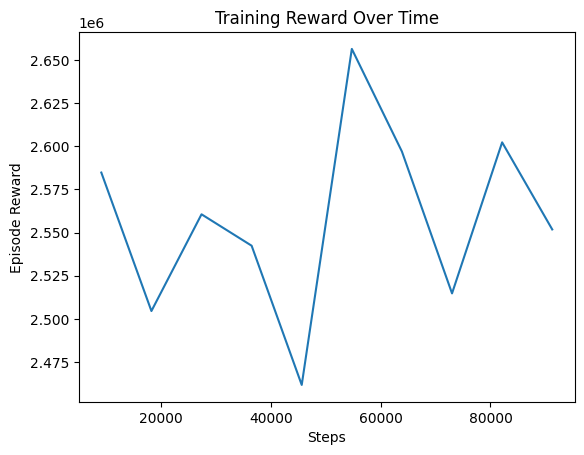

In [30]:
plt.plot(reward_df['step'], reward_df['value'])
plt.xlabel("Steps")
plt.ylabel("Episode Reward")
plt.title("Training Reward Over Time")
plt.show()

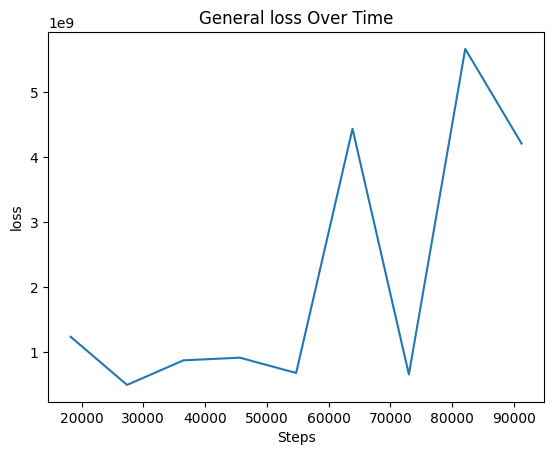

In [31]:
plt.plot(loss['step'], loss['value'])
plt.xlabel("Steps")
plt.ylabel("loss")
plt.title("General loss Over Time")
plt.show()

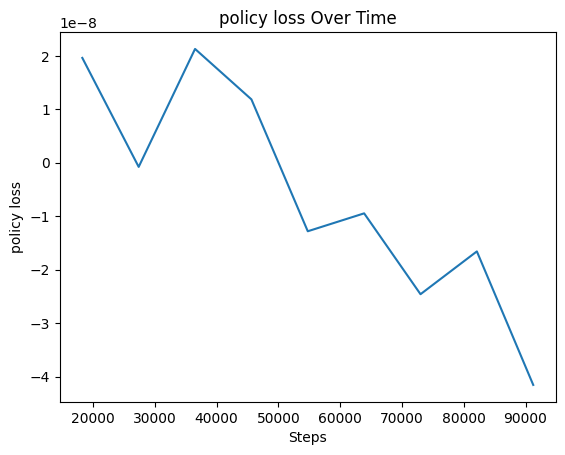

In [32]:
plt.plot(policy_loss['step'], policy_loss['value'])
plt.xlabel("Steps")
plt.ylabel("policy loss")
plt.title("policy loss Over Time")
plt.show()

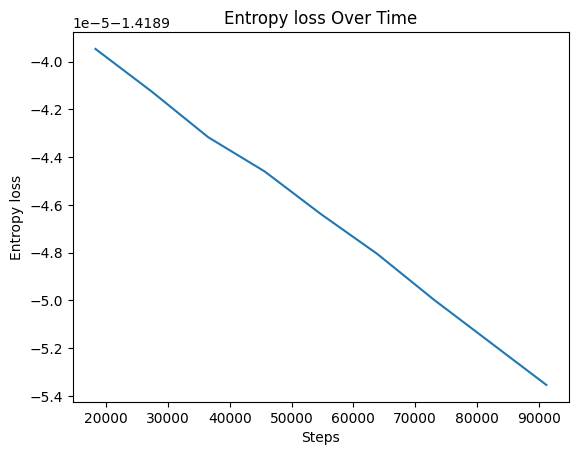

In [33]:
plt.plot(ent_loss['step'], ent_loss['value'])
plt.xlabel("Steps")
plt.ylabel("Entropy loss")
plt.title("Entropy loss Over Time")
plt.show()

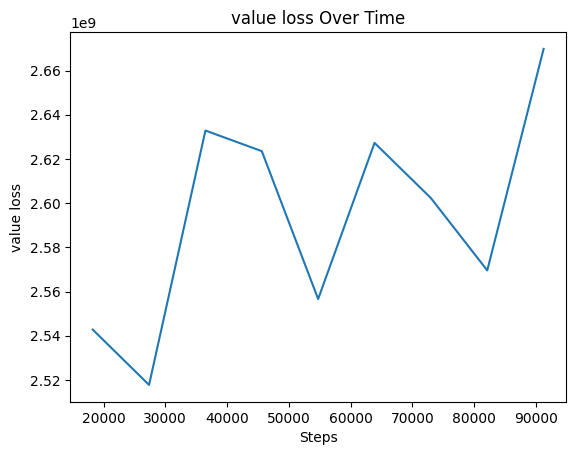

In [34]:
plt.plot(value_loss['step'], value_loss['value'])
plt.xlabel("Steps")
plt.ylabel("value loss")
plt.title("value loss Over Time")
plt.show()

In [35]:
print(f"Mean training reward: {reward_df['value'].mean()}, Mean value loss: {value_loss['value'].mean()}, Mean policy loss: {policy_loss['value'].mean()}, Mean entropy loss {ent_loss['value'].mean()}, Mean total loss {ent_loss['value'].mean()}")

Mean training reward: 2557623.1, Mean value loss: 2593622840.888889, Mean policy loss: -5.886615590040062e-09, Mean entropy loss -1.4189464648564656, Mean total loss -1.4189464648564656


In [36]:
dummy_vec_env = DummyVecEnv([make_reservoir_env(data=test_data,rank=rank,base_initial_index=0, n_envs=25,eval_mode=True)
                         for rank in range(25,50)])
eval_env = VecMonitor(dummy_vec_env)

In [40]:
eval_reward, std = evaluate_policy(model, eval_env, n_eval_episodes=80,return_episode_rewards=True)

In [41]:
print(f'Mean evaluation reward: {np.mean(eval_reward)}')

Mean evaluation reward: 2000125.375


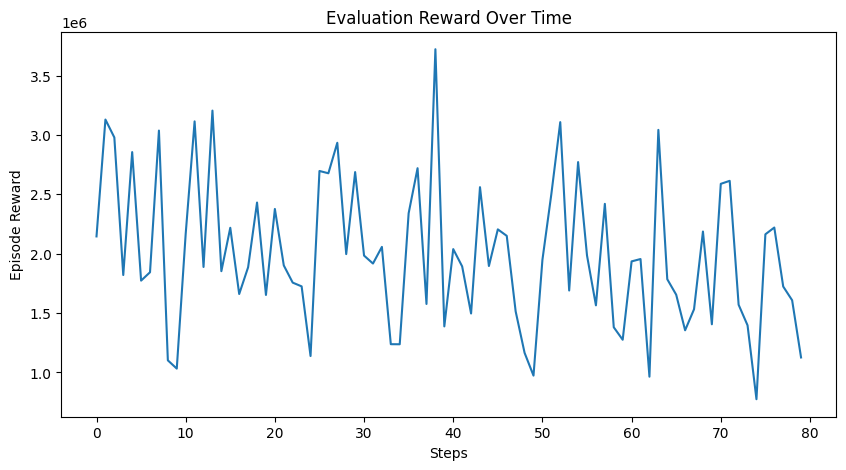

In [42]:
plt.figure(figsize=(10,5))
plt.plot(eval_reward)
plt.xlabel("Steps")
plt.ylabel("Episode Reward")
plt.title("Evaluation Reward Over Time")
plt.show()